<a href="https://colab.research.google.com/github/prateek0489/100daysToDS/blob/master/Fastai_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 23kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
import string

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def add_features(dataframe):
  dataframe['tweet_contains_url'] = dataframe['tweet'].apply(lambda x: len(re.findall("(?P<url>https?://[^\s]+)", x)))
  dataframe['tweet_contains_positive_smiley'] =dataframe['tweet'].apply(lambda x: len(re.findall(":\)|;\)+", x)))
  dataframe['tweet_contains_negative_smiley'] =dataframe['tweet'].apply(lambda x: len(re.findall(":\(|;\(+", x)))
  return dataframe

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

def clean_text(text):
    text = re.sub("(?P<url>https?://[^\s]+)","",text)
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords and len(word)>3]
    return text

def createfinaldata(dataframe):
  dataframe['body_text_nostop'] = dataframe['tweet'].apply(lambda x: clean_text(x.lower()))
  dataframe['body_text_lemmatized'] = dataframe['body_text_nostop'].apply(lambda x: lemmatizing(x))
  dataframe['tidy_tweet']=dataframe['body_text_lemmatized'].apply(lambda x:" ".join([word for word in x]))
  return dataframe

In [0]:
training_data=pd.read_csv("train.csv")
training_data_with_added_features=add_features(training_data)
final_data=createfinaldata(training_data_with_added_features)
final_data.head()


In [0]:
model_data=final_data[['label','tidy_tweet']]

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(model_data, stratify = model_data['label'], test_size = 0.4, random_state = 12)

In [19]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [28]:
learn = language_model_learner(data_lm,AWD_LSTM,  drop_mult=0.7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


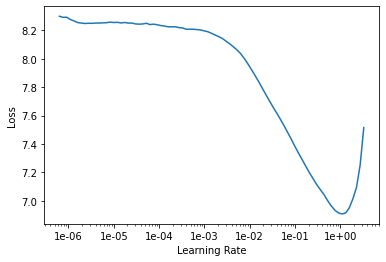

In [29]:
learn.lr_find() # find learning rate
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.077847,7.398096,0.105190,01:59


In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

In [36]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.605189,0.422818,0.830177,01:36


In [41]:
learn.predict("I really hated that phone")

(Category 1, tensor(1), tensor([0.3471, 0.6529]))

In [48]:
learn.predict("Thats a great phone")

(Category 0, tensor(0), tensor([0.5630, 0.4370]))

In [46]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,2153,333
1,205,477


In [0]:
test_data=pd.read_csv('test.csv')

In [0]:
test_data_with_added_features=add_features(test_data)
final_test_data=createfinaldata(test_data_with_added_features)


In [73]:
learn.predict([final_test_data['tidy_tweet'])[0]

Category 0

In [0]:
final_test_data['label']=final_test_data['tidy_tweet'].apply(lambda x:learn.predict(x)[0])

In [82]:
test

,tidy_tweet,prediction
0,hate iphone upgrade wont download apps apple suck,1
1,currently shitting fucking pant apple imac cas...,1
2,like put cdroms ipad possible wouldnt block sc...,1
3,ipod officially dead lost picture video 5sos c...,0
4,fighting itunes night want music paid,1
5,repost getbakednfried repostapp announce apple...,0
6,apple software update really thing phone thing...,1
7,baby iphone iphone6s gold apple appleisbest 64...,0
8,confusedwhy take time appointment still waitin...,1
9,fruit taste better pick apple healthy fruit pi...,0
